### Customer Segmentation with RFM score and K-Means on Superstore dataset

In [342]:
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt


In [878]:
import plotly.io as pio
pio.renderers.default = "svg"

In [10]:
!kaggle datasets list -s 'jr2ngb'


ref                     title             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------  ----------------  ----  -------------------  -------------  ---------  ---------------  
jr2ngb/superstore-data  superstore_data    3MB  2019-01-30 06:49:17           7978        102  0.5294118        
jr2ngb/cataractdataset  cataract dataset   3GB  2019-08-23 07:29:23           2590         50  0.6875           


In [13]:
!kaggle datasets download jr2ngb/superstore-data -f superstore_dataset2011-2015.csv


  0%|          | 0.00/2.74M [00:00<?, ?B/s]
 37%|###6      | 1.00M/2.74M [00:01<00:01, 1.02MB/s]
 73%|#######3  | 2.00M/2.74M [00:02<00:00, 1.02MB/s]
100%|##########| 2.74M/2.74M [00:02<00:00, 1.17MB/s]
100%|##########| 2.74M/2.74M [00:02<00:00, 1.15MB/s]


In [393]:
df = pd.read_csv('superstore_dataset2011-2015.csv.zip', encoding= 'iso-8859-1')
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [37]:
df.isna().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Missing values in postal code are negligible for our analysis. If needed they could be retrieved, and some of them could probably be imputed. 

In [872]:
df['Customer ID'].nunique()

1590

In [871]:
len(df)

51290

1590 users with a total of 51290 will do nicely for our segmentation

In [40]:
df['Category'].value_counts()

Office Supplies    31273
Technology         10141
Furniture           9876
Name: Category, dtype: int64

In [43]:
print('First order recoreded at',df['Order Date'].min() )
print('Last order recorded at',df['Order Date'].max() )

First order recoreded at 2011-01-01 00:00:00
Last order recorded at 2014-12-31 00:00:00


Let's create a reference date to calculate the recency score. We could also use the present day date but chosing a reference date shortly after the last order provides a better impression.

In [44]:
reference_date = datetime(2015,1,1) 

In [45]:
print('Before dropping duplicates: ', len(df))

Before dropping duplicates:  51290


In [46]:
df = df.drop_duplicates()

In [47]:
print('After dropping duplicates: ', len(df))

After dropping duplicates:  51290


## Recency, Frequency and Monetary (RFM) Score

In [184]:
rfm= df.groupby('Customer ID').agg({    'Order Date': lambda date: (reference_date - date.max()).days,
                                        'Order ID': lambda num: len(num),
                                        'Profit': lambda profit: profit.sum(),
                                        'Sub-Category':  lambda x:x.value_counts().index[0],

                                   }).reset_index().rename(columns ={'Order Date':'r', 'Order ID':'f', 
                                                                       'Profit':'m', 'Customer ID':'customer_id'})
                                     

In [185]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   1590 non-null   object 
 1   r             1590 non-null   int64  
 2   f             1590 non-null   int64  
 3   m             1590 non-null   float64
 4   Sub-Category  1590 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 62.2+ KB


### Checking for outliers

Text(0.5, 1.0, 'recency')

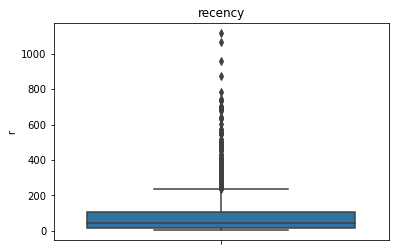

In [186]:
sns.boxplot(y=rfm["r"]).set_title('recency')


Text(0.5, 1.0, 'frequency')

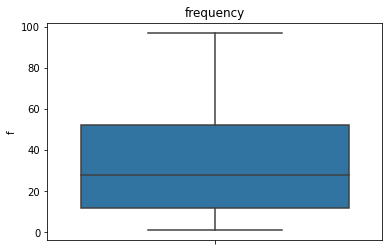

In [187]:
sns.boxplot(y=rfm["f"]).set_title('frequency')


Text(0.5, 1.0, 'monetary')

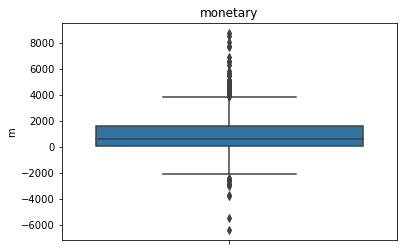

In [188]:
sns.boxplot(y=rfm["m"]).set_title('monetary')


### Removing outliers by IQR method

In [189]:
def get_thresholds(column):
    outliers_thresholds = []
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    positive = q3 +(1.5*iqr)
    negative = q1 - (1.5*iqr)
    
    outliers_thresholds.append(positive)
    outliers_thresholds.append(negative)

    return outliers_thresholds
    

In [190]:
monetary = get_threshold(rfm["m"])

In [191]:
monetary[1]

-2184.7004625000004

In [192]:
r_threshold = get_threshold(rfm['r'])


In [193]:
r_threshold[0]

237.5

In [194]:
rfm_iqr = rfm.loc[(rfm['r'] <= r_threshold[0])]
len(rfm_iqr)

1437

In [195]:
r_threshold = get_threshold(rfm['r'])
r_threshold

[237.5, -118.5]

In [196]:
r_threshold = get_threshold(rfm['m'])
r_threshold

[3893.9994375000006, -2184.7004625000004]

Monetary outliers by IQR


In [874]:
m_threshold = get_threshold(rfm['m'])
print('MONETARY  IQR threshold: ', m_threshold)
rfm_iqr = rfm_iqr.loc[(rfm['m'] <= m_threshold[0]) & (rfm['m'] >= m_threshold[1])]
print('df size after removing MONETARY outliers: ', len(rfm_iqr))


MONETARY  IQR threshold:  [3893.9994375000006, -2184.7004625000004]
df size after removing MONETARY outliers:  1380


Recency outliers by IQR


In [198]:
r_threshold = get_threshold(rfm['r'])
print('RECENCY  IQR threshold: ', r_threshold)
rfm_iqr = rfm_iqr.loc[(rfm['r'] <= r_threshold[0])]
print('df size after removing RECENCY outliers: ', len(rfm_iqr))


RECENCY  IQR threshold:  [237.5, -118.5]
df size after removing RECENCY outliers:  1380


In [199]:
rfm2 = rfm_iqr

In [200]:
rfm2['r_quartile'] = pd.qcut(rfm2['r'], 4, ['1','2','3','4']) #'1','2','3','4'
rfm2['f_quartile'] = pd.qcut(rfm2['f'].rank(method='first'), 4, ['4','3','2','1'])
rfm2['m_quartile'] = pd.qcut(rfm2['m'], 4, ['4','3','2','1'])

Let's merge these scores together in a new column as a string

In [201]:
rfm2['rfm_score'] = rfm2['r_quartile'].astype(str)+ rfm2['f_quartile'].astype(str) + rfm2['m_quartile'].astype(str)


In [202]:
rfm2['rfm_score'].value_counts()

444    86
111    71
443    71
211    54
121    48
       ..
342     3
313     2
414     2
413     2
441     2
Name: rfm_score, Length: 61, dtype: int64

In [203]:
rfm2.head()

,customer_id,r,f,m,Sub-Category,r_quartile,f_quartile,m_quartile,rfm_score
0,AA-10315,9,42,447.69050,Binders,1,2,3,123
1,AA-10375,7,42,677.47740,Storage,1,2,2,122
2,AA-10480,118,38,1516.47518,Storage,4,2,2,422
3,AA-10645,27,73,3051.43900,Storage,2,1,1,211
4,AA-315,3,8,535.56600,Binders,1,4,3,143


The 'rfm_score' column could be attached to the original df to provide a quick evaluation of customers.

## Clustering

Using those rfm values and the additional column 'Sub-Category' we can do clustering with K-Means. The previously created string column 'rfm_score' won't be considered. Instead we will use the columns for 'r_quartile', 'f_quartile' and 'm_quartile'.

In [225]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px


In [205]:
rfm2

,customer_id,r,f,m,Sub-Category,r_quartile,f_quartile,m_quartile,rfm_score
0,AA-10315,9,42,447.69050,Binders,1,2,3,123
1,AA-10375,7,42,677.47740,Storage,1,2,2,122
2,AA-10480,118,38,1516.47518,Storage,4,2,2,422
3,AA-10645,27,73,3051.43900,Storage,2,1,1,211
4,AA-315,3,8,535.56600,Binders,1,4,3,143
...,...,...,...,...,...,...,...,...,...
1585,YS-21880,10,54,3091.59430,Binders,1,1,1,111
1586,ZC-11910,201,1,-15.56700,Paper,4,4,4,444
1587,ZC-21910,4,84,452.50326,Binders,1,1,3,113
1588,ZD-11925,4,18,478.41600,Art,1,3,3,133


In [217]:
df2 = rfm2

In [218]:
df2 = df2[['r_quartile','f_quartile','m_quartile','Sub-Category']]

Getting dummy variables for 'Sub-Category'

In [220]:
df2 = pd.get_dummies(data=df2, columns=['Sub-Category'])


In [222]:
df2.head(3)

,r_quartile,f_quartile,m_quartile,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies
0,1,2,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [223]:
scaler = MinMaxScaler()


In [224]:
df3 = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)


In [235]:
df3

,r_quartile,f_quartile,m_quartile,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies
0,0.000000,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,1.000000,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1376,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1377,0.000000,0.000000,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1378,0.000000,0.666667,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Determining K for K-Means by using silhouette score

In [232]:
silhouette_list = []

In [236]:
for i in range(2,15):
    
    kmeans = KMeans(n_clusters= i, random_state= 42)
    
    kmeans.fit(df3)
    label=kmeans.predict(df3)
    
    silhouette = silhouette_score(df3, label)
    silhouette_list.append(silhouette)

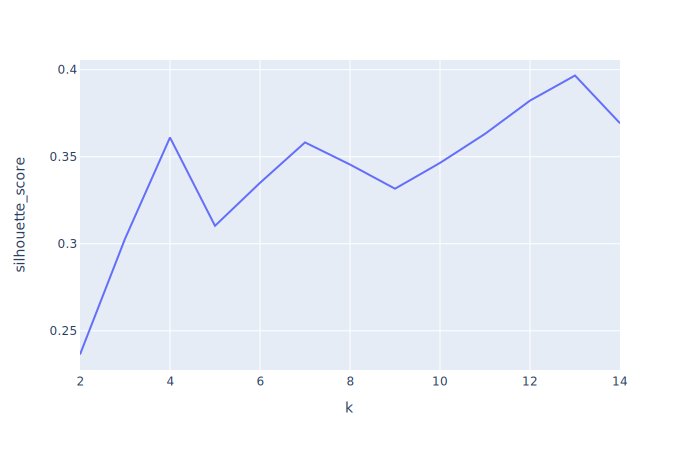

In [879]:
line = px.line(x=range(2,15), y = silhouette_list )
line.update_layout(width = 600, height = 400, yaxis = dict(title = 'silhouette_score'), xaxis = dict(title = 'k'))
line.show()

Since in the original df the creators came up with three segments, 13 cluster seem to be a bit of an overkill. So we will take a look at 7. Choosing 4 would probably provide a result that is too close to the original segments.  

In [253]:
kmeans = KMeans(n_clusters= 7)
    
kmeans.fit(df3)
predict=kmeans.predict(df3)

In [254]:
df3.index = rfm2.index
rfm2.index.equals(df3.index)


True

In [255]:
rfm2['Cluster'] = pd.Series(predict, index=df2.index)


In [256]:
rfm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1380 entries, 0 to 1589
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   1380 non-null   object 
 1   r             1380 non-null   int64  
 2   f             1380 non-null   int64  
 3   m             1380 non-null   float64
 4   Sub-Category  1380 non-null   object 
 5   r_quartile    1380 non-null   int32  
 6   f_quartile    1380 non-null   int32  
 7   m_quartile    1380 non-null   int32  
 8   rfm_score     1380 non-null   object 
 9   Cluster       1380 non-null   int32  
dtypes: float64(1), int32(4), int64(2), object(3)
memory usage: 137.0+ KB


In [257]:
rfm2[['r_quartile', 'f_quartile','m_quartile']] = rfm2[['r_quartile', 'f_quartile','m_quartile']].astype(int)

In [260]:
df_cluster = rfm2.groupby('Cluster').agg({    'r_quartile': lambda q: q.median(),
                                        'f_quartile': lambda q: q.median(),
                                        'm_quartile': lambda q: q.median(),
                                        'Sub-Category': lambda x:x.value_counts().index[0],
                                       
                                
                                  
                                        })

In [261]:
df_cluster

,r_quartile,f_quartile,m_quartile,Sub-Category
Cluster,,,,
0,3,4,3,Furnishings
1,2,1,2,Binders
2,3,3,3,Art
3,3,3,3,Binders
4,3,3,3,Storage
5,2,2,2,Chairs
6,2,2,1,Paper


Cluster 0 - 343: This cluster primarily shops Furnishings, and as it comes with this typ of high involvement product. It is shopped very infrequently, and also at little profit.

Cluster 1 - 212: Binders are the main interest of this cluster, and they shop very frequently. They are one of the most profitable clusters. 

Cluster 2 - 333: Similar to cluster 0 in recency and monetary value. The difference being that Art is purchased a little bit more frequently. 

Cluster 3 - 333: Same as cluster 2 but for Binders customers

Cluster 4 - 333: Same as cluster 2 but for Storage customers

Cluster 5 - 222: The customers primarily buying chairs are among top customers. They shop frequently and are provide good monetary value. 

Chapter 6 - 221: The cluster with the highest monetary value also has good recency and frequency scores. Customers purchasing primarily Paper are in the best performing cluster.

Focus on clusters 1, 5 and 6. Search for improvements for clusters 2, 3 and 4